In [147]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw1.ok')

Assignment: hw1
OK, version v1.14.11



# Homework 1 - INT 15

![election_prediction](http://donsnotes.com/politics/images/clinton-trump-rating.png)

We haven't yet talked about predictive models in class yet, but we can at least think about what makes a "good" prediction.  In this assignment, we'll focus on evaluating the quality of election predictions made by the website [fivethirtyeight.com](https://www.fivethirtyeight.com).  As one prominent example, fivethirtyeight predicted that Clinton had a 70.9% chance to win the election.  Was their model wrong?

To gain insight into questions like this, we'll focus on  [US House elections predictions from 2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/).  Their predictions are based predominantly on polling data but include other sources as well (state of the economy, overall favoriability of politic parties, etc).  

This homework is based loosely on [this article](https://projects.fivethirtyeight.com/checking-our-work/).  Please read the article before beginning the assignment.


In [148]:
!wget https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv

--2019-04-19 20:00:31--  https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24027649 (23M) [text/plain]
Saving to: ‘us_house_elections.csv.9’

us_house_elections. 100%[===================>]  22.91M   116MB/s    in 0.2s    

2019-04-19 20:00:31 (116 MB/s) - ‘us_house_elections.csv.9’ saved [24027649/24027649]



`ls` command can be used to verify that the file is now listed in our folder.   

In [149]:
!ls -F -l

total 235468
-rw-rw-r-- 1 jovyan users   194919 Apr 19 19:47 hw1.ipynb
-rw-rw-r-- 1 jovyan users      162 Apr 11 17:10 hw1.ok
-rw-r--r-- 1 jovyan users   562029 Apr 19 19:19 mlb_games.csv
drwxrwsr-x 3 jovyan users     4096 Apr 11 17:11 tests/
-rw-rw-r-- 1 jovyan users 24027649 Apr 11 17:10 us_house_elections.csv
-rw-rw-r-- 1 jovyan users 24027649 Apr 11 17:10 us_house_elections.csv.1
-rw-rw-r-- 1 jovyan users 24027649 Apr 11 17:11 us_house_elections.csv.2
-rw-rw-r-- 1 jovyan users 24027649 Apr 12 20:02 us_house_elections.csv.3
-rw-rw-r-- 1 jovyan users 24027649 Apr 16 02:20 us_house_elections.csv.4
-rw-rw-r-- 1 jovyan users 24027649 Apr 16 18:12 us_house_elections.csv.5
-rw-rw-r-- 1 jovyan users 24027649 Apr 18 17:15 us_house_elections.csv.6
-rw-r--r-- 1 jovyan users 24027649 Apr 19 06:23 us_house_elections.csv.7
-rw-r--r-- 1 jovyan users 24027649 Apr 19 19:16 us_house_elections.csv.8
-rw-r--r-- 1 jovyan users 24027649 Apr 19 20:00 us_house_elections.csv.9


In [150]:
import pandas as pd ## call pandas functions using "pd"
import numpy as np  ## call numpy functions using "np"
election_data = pd.read_csv("us_house_elections.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Examining the Data

Display the first 10 rows of the dataset using `iloc`.

In [151]:
election_data.iloc[0:10]

,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome
0,2018,House,WY,1.0,False,2018-11-06,2018-11-06,lite,D,Greg Hunter,33.29836,NaN,0.00134,0
1,2018,House,WY,1.0,False,2018-11-06,2018-11-06,lite,R,Liz Cheney,61.18835,NaN,0.99866,1
2,2018,House,WY,1.0,False,2018-11-06,2018-11-06,deluxe,D,Greg Hunter,31.37998,NaN,0.00020,0
3,2018,House,WY,1.0,False,2018-11-06,2018-11-06,deluxe,R,Liz Cheney,63.10673,NaN,0.99980,1
4,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,D,Greg Hunter,31.33293,NaN,0.00032,0
5,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,R,Liz Cheney,63.15379,NaN,0.99968,1
6,2018,House,WV,3.0,False,2018-11-06,2018-11-06,lite,D,Richard Neece Ojeda,47.56779,NaN,0.27966,0
7,2018,House,WV,3.0,False,2018-11-06,2018-11-06,lite,R,Carol Devine Miller,52.43221,NaN,0.72034,1
8,2018,House,WV,3.0,False,2018-11-06,2018-11-06,deluxe,D,Richard Neece Ojeda,45.14111,NaN,0.09662,0
9,2018,House,WV,3.0,False,2018-11-06,2018-11-06,deluxe,R,Carol Devine Miller,54.85889,NaN,0.90338,1


Fivethirtyeight has three different prediction models: `lite`, `classic` and `deluxe`, which roughly incorporate an increasing number of assumptions.  In this assignment lets focus on evaluting the quality of the `classic` predictions.  You can read more about how the prediction models work [here](https://fivethirtyeight.com/methodology/how-fivethirtyeights-house-and-senate-models-work/).

Fivethirtyeight continuously updated their predictions as more polling data became available for each of the races.  Let's focus on the predictions a few months before the election, on August 11th, and on the morning of election day, November 6th.  

### Question 1

Create a new pandas dataframe called `election_sub` by filtering to include only rows in which the `forecast_type` is "classic", and the date of the foreceast (`forecast_date`) is 8/11 or 11/6.

<!--
BEGIN QUESTION
name: q1
manual: false
points: 2
-->

In [152]:
election_sub = election_data[(election_data['forecast_type'] == 'classic') & ((election_data['forecast_date'] == '2018-11-06') | (election_data['forecast_date'] == '2018-08-11'))]
election_sub

,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome
4,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,D,Greg Hunter,31.332930,NaN,0.00032,0
5,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,R,Liz Cheney,63.153790,NaN,0.99968,1
10,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,D,Richard Neece Ojeda,44.295840,NaN,0.07366,0
11,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,R,Carol Devine Miller,55.704160,NaN,0.92634,1
18,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,D,Talley Sergent,43.099960,NaN,0.06562,0
19,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,I,Daniel Lutz Jr.,3.207378,NaN,0.00000,0
20,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,R,Alex X. Mooney,53.692660,NaN,0.93438,1
25,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,D,Kendra Fershee,37.357480,NaN,0.00042,0
26,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,R,David B. McKinley,62.642520,NaN,0.99958,1
31,2018,House,WI,8.0,False,2018-11-06,2018-11-06,classic,D,Beau Liegeois,39.092470,NaN,0.00468,0


In [153]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2

We want to check whether events predicted by 538 to occur with probability _close to_ X% actually occured about X% of the time.  To do this, we have to define _close_.  First, we'll define the `cut_points` as 20 equally spaced numbers between 0 and 1 using `np.linspace`.  Then we'll group the predicted probabilities into the `19` equally spaced bins determined by those cut points.  Define the bin for each observation using the `pd.cut` function on the `probwin` variable.  We'll assign the result to a new column of `election_sub` called `bin`.

<!--
BEGIN QUESTION
name: q2
manual: false
points: 2
-->

In [154]:
cut_points = np.linspace(0, 1, 20)
election_sub['bin'] = pd.cut(election_sub['probwin'], cut_points)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [155]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 3

Now we've grouped the observations into a discrete set of bins according to the predicted probability, `probwin`.  Within each bin, we now want to compute the actual fraction of times the candidates won. If 538 did a good job, it will be close to the predited probabilities.   You'll need to use the `groupby` function to compute the mean of `probwin_outcome` (1 is a win and 0 is a loss) within each bin.  Save the fraction of actual wins in each bin in a list called `fraction_outcome`.

<!--
BEGIN QUESTION
name: q3
manual: false
points: 2
-->

In [156]:
fraction_outcome = election_sub.groupby('bin')['probwin_outcome'].mean()
list(fraction_outcome)

[0.0017152658662092624,
 0.0625,
 0.023255813953488372,
 0.14285714285714285,
 0.2,
 0.058823529411764705,
 0.23529411764705882,
 0.2727272727272727,
 0.4666666666666667,
 0.5,
 0.5333333333333333,
 0.7272727272727273,
 0.7647058823529411,
 0.9411764705882353,
 0.8,
 0.8571428571428571,
 0.9767441860465116,
 0.9375,
 0.9984779299847792]

In [157]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4

For this problem we'll make a plot of the predicted probabilities and actual fraction of wins in each bin.  We've already computed the actual fraction of wins; all that remains is to plot it against the predicted value assocaited with each bin.  For the predicted value in each bin, we'll use the midpoint of the bin.  Compute the midpoints of each bin from `cut_points`.

<!--
BEGIN QUESTION
name: q4
manual: false
points: 2
-->

In [158]:
print(cut_points)
midpoints = (cut_points[0:19] + cut_points[1:20])/2
print(midpoints)

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[0.02631579 0.07894737 0.13157895 0.18421053 0.23684211 0.28947368
 0.34210526 0.39473684 0.44736842 0.5        0.55263158 0.60526316
 0.65789474 0.71052632 0.76315789 0.81578947 0.86842105 0.92105263
 0.97368421]


In [159]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now make a scatterplot using `midpoints` as the x variable and `fraction_outcome` as the y variable.  Draw a dashed line from `[0,0]` to `[1,1]` to mark the line y=x.  

    midpoints  fraction_outcome
0    0.026316          0.001715
1    0.078947          0.062500
2    0.131579          0.023256
3    0.184211          0.142857
4    0.236842          0.200000
5    0.289474          0.058824
6    0.342105          0.235294
7    0.394737          0.272727
8    0.447368          0.466667
9    0.500000          0.500000
10   0.552632          0.533333
11   0.605263          0.727273
12   0.657895          0.764706
13   0.710526          0.941176
14   0.763158          0.800000
15   0.815789          0.857143
16   0.868421          0.976744
17   0.921053          0.937500
18   0.973684          0.998478


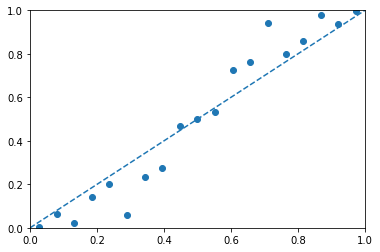

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt
midfrac = pd.DataFrame(
    {'midpoints':list(midpoints),
    'fraction_outcome':list(fraction_outcome)})
print(midfrac)
plt.scatter(x = midfrac['midpoints'], y = midfrac['fraction_outcome'])
plt.plot([0, 1], [0, 1], '--')
plt.axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
plt.show()


### Question 5: adding error bars

If you did things correctly, it should look like fivethirtyeight has done "pretty" well with their forecasts: the actual fraction of wins tracks closely with the predicted number.  But how do we decide what's "good enough"? Consider this example: I correctly predict that a coin is fair (e.g. that it has a 50% chance of heads, 50% chance of tails).  But if I flip it 100 times, I can be pretty sure it won't come up heads exactly 50 times.  The fact that it didn't come up heads exactly 50 times doesn't make my prediction incorrect.

To assess how reasonable the predictions are, I need to quantify the uncertainty in my estimate.  It's reasonable to assume that within each bin, $k$, the observed number of wins, $Y_k \sim Bin(n_k, p_k)$, where $n_k$ is the number of elections and $p_k$ is the predicted win probability in bin $k$.

Classical results tell us that the obseved fraction of wins in bin $k$, $\hat p = \frac{Y_k}{n_k}$ has variance Var$\left(\hat p_k\right) = \frac{p_k (1-p_k)}{n_k} \approx \frac{\hat p_k(1- \hat p_k)}{n_k}$.  The standard deviation of the Binomial proportion then is $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$.  

If we use the [normal approximation to generate a confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval), then the 95% interval has the form $\hat p_k \pm 1.96 \hat \sigma_k$.


Create a new "aggregated" dataframe.  This time, group `election_sub` by the `bin` and compute both the average of the `probwin_outcome` (`mean`) and the number of observations in each bin (`count`) using the `agg` function.  Call this new data frame, `election_agg`.

In [161]:
election_agg = pd.DataFrame({'mean':election_sub.groupby('bin')['probwin_outcome'].size(), 'count':election_sub.groupby('bin')['probwin_outcome'].mean()})
election_agg.columns = ['count', 'mean']
election_agg

,count,mean
bin,,
"(0.0, 0.0526]",583,0.001715
"(0.0526, 0.105]",32,0.062500
"(0.105, 0.158]",43,0.023256
"(0.158, 0.211]",28,0.142857
"(0.211, 0.263]",30,0.200000
"(0.263, 0.316]",17,0.058824
"(0.316, 0.368]",17,0.235294
"(0.368, 0.421]",22,0.272727
"(0.421, 0.474]",15,0.466667


Use the `mean` and `count` columns of `election_agg` to create a new column of `election_agg` titled `err`, which stores $1.96 \times \hat \sigma_k$ in each bin $k$.

In [162]:
mean = election_agg['mean']
count = election_agg['count']
election_agg['err'] = 1.96*((mean*(1-mean)*mean)/count)**.5
election_agg

,count,mean,err
bin,,,
"(0.0, 0.0526]",583,0.001715,0.000139
"(0.0526, 0.105]",32,0.062500,0.020968
"(0.105, 0.158]",43,0.023256,0.006870
"(0.158, 0.211]",28,0.142857,0.048990
"(0.211, 0.263]",30,0.200000,0.064013
"(0.263, 0.316]",17,0.058824,0.027128
"(0.316, 0.368]",17,0.235294,0.097811
"(0.368, 0.421]",22,0.272727,0.097190
"(0.421, 0.474]",15,0.466667,0.172471


Use `plt.errorbar` to create a new plot with error bars associated with the actual fraction of wins in each bin.  Again add a dashed y=x line.  Set the argument `fmt='.'` to create a scatterplot with errorbars.

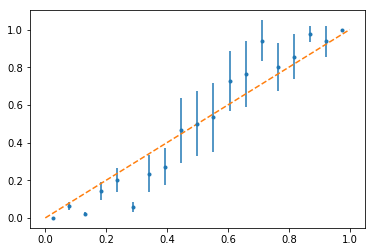

In [163]:
plt.errorbar(midpoints, election_agg['mean'].values, yerr=election_agg['err'].values, fmt='.')
plt.plot([0, 1], [0, 1], '--')

### Question 6: computing the coverage

If our intervals were true 95% confidence intervals, then we would expect about 95% of them to cover the midpoint of the bin (i.e. overlap with the y=x line).  What fraction of the 95% confidence intervals cover the bin midpoint?  Create a list called `upper` to be the `mean` + `err` and another `lower` to be `mean` - `err`.  Next, compute `frac_covering` as the fraction of midpoints between `lower` and `upper`. 

<!--
BEGIN QUESTION
name: q5
manual: false
points: 2
-->

In [164]:
upper = list(election_agg['mean'] + election_agg['err'])
lower = list(election_agg['mean'] - election_agg['err'])
frac_covering = ((midpoints < upper) & (midpoints > lower)).mean()
frac_covering
election_sub

,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome,bin
4,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,D,Greg Hunter,31.332930,NaN,0.00032,0,"(0.0, 0.0526]"
5,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,R,Liz Cheney,63.153790,NaN,0.99968,1,"(0.947, 1.0]"
10,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,D,Richard Neece Ojeda,44.295840,NaN,0.07366,0,"(0.0526, 0.105]"
11,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,R,Carol Devine Miller,55.704160,NaN,0.92634,1,"(0.895, 0.947]"
18,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,D,Talley Sergent,43.099960,NaN,0.06562,0,"(0.0526, 0.105]"
19,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,I,Daniel Lutz Jr.,3.207378,NaN,0.00000,0,NaN
20,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,R,Alex X. Mooney,53.692660,NaN,0.93438,1,"(0.895, 0.947]"
25,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,D,Kendra Fershee,37.357480,NaN,0.00042,0,"(0.0, 0.0526]"
26,2018,House,WV,1.0,False,2018-11-06,2018-11-06,classic,R,David B. McKinley,62.642520,NaN,0.99958,1,"(0.947, 1.0]"
31,2018,House,WI,8.0,False,2018-11-06,2018-11-06,classic,D,Beau Liegeois,39.092470,NaN,0.00468,0,"(0.0, 0.0526]"


In [168]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q5 > Suite 1 > Case 1

>>> isinstance(candidate, str)
NameError: name 'candidate' is not defined

# Error: expected
#     True
# but got
#     Traceback (most recent call last):
#       ...
#     NameError: name 'candidate' is not defined

Run only this test case with "python3 ok -q q5 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



### Question 7: understanding confidence intervals

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the confidence intervals?

Based on the plot above, the intervals farther from 0 and 1 (less confident predictions) have larger confidence intervals. Some factors include the variance which is greatest at at p = .5 from 0 to 1. Another length is the level of confidence we want. The greater the level, the greater the confidence. The smaller the level, the less the confidence.

### Question 8: finding the candidate that had the biggest change in support

Let's see if we can find the candidate that seemed to improve their standing the most between  August 11 and November 6.  First, fill in the function `abs_diff`, which takes in a pandas data frame and computes the difference between the largest values of `probwin` and the smallest value.  



In [183]:
# Input: a pandas dataframe with a numeric column named `probwin`
# Output: a pandas dataframe with the same columns, with an additional column named `absdiff`
def abs_diff(x):
    x['absdiff'] = abs(x['probwin'].max() - x['probwin'].min())
    return x

We can use this function to compute the difference between the maximum and minimum predicted with probabilities for every candidate.  To do so, group `election_sub` by `candidate` and `apply` the function `abs_diff`.  Find the index of the largest difference in `diff_dataframe` and store it in `max_idx`.  Do this using `np.nanargmax` function.  This function finds the _index_ of the largest value, ignoring any missing values (`nans`). 

In [189]:
diff_dataframe = election_sub.groupby('candidate').apply(abs_diff)
max_idx = diff_dataframe['absdiff'].argmax()
diff_dataframe.loc[max_idx]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


year                             2018
office                          House
state                              KS
district                            3
special                         False
election_date              2018-11-06
forecast_date              2018-11-06
forecast_type                 classic
party                               D
candidate              Sharice Davids
projected_voteshare           51.8511
actual_voteshare                  NaN
probwin                       0.84994
probwin_outcome                     1
bin                    (0.842, 0.895]
absdiff                       0.65428
Name: 1890, dtype: object

<!--
BEGIN QUESTION
name: q5
manual: false
points: 2
-->

In [187]:
candidate = diff_dataframe.loc[max_idx]['candidate']
candidate

'Sharice Davids'

In [188]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Did the candidate win or lose the election?

*Write your answer here, replacing this text.*

### Question 9: plot predictions over time

Plot the forecasted win probability for the candidate you found above, for every available date.  For this you'll need to return to working with the full `election_data`, not `election_sub`.  Don't forget, you should still filter to `classic` forecasts only.  First, create an array of `predicted_probs` for the candidate at every date.  Also save the date in an array called `forecast_date`.  When creating `forecast_date`, use `pd.to_datetime` to convert a `str` datatype to the date format that can easily be plotted.

<!--
BEGIN QUESTION
name: q6
manual: false
points: 2
-->

In [206]:
election_data
predicted_probs = election_data[(election_data['forecast_type'] == 'classic') &
                                (election_data['candidate'] == 'Sharice Davids')]['probwin']
forecast_date = pd.to_datetime(election_data[(election_data['forecast_type'] == 'classic') &
                                (election_data['candidate'] == 'Sharice Davids')]['forecast_date'])

In [207]:
ok.grade("q6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Now create a lineplot with forecast date on the x-axis and the predicted win probability on the y-axis.

[Text(0, 0.5, 'Predicted Probability'),
 Text(0.5, 0, 'Forecast Date'),
 Text(0.5, 1.0, 'Date vs Predicted Probability')]

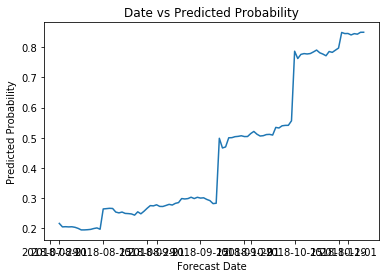

In [225]:
fig,ax = plt.subplots()
ax.plot(forecast_date, predicted_probs)
ax.set(title = 'Date vs Predicted Probability', xlabel = 'Forecast Date', ylabel = 'Predicted Probability')



### Question 10: prediction histograms

Make a histogram showing the predicted win probabilities on the morning of the election.  Again, restrict yourself to only the `classic` predictions.

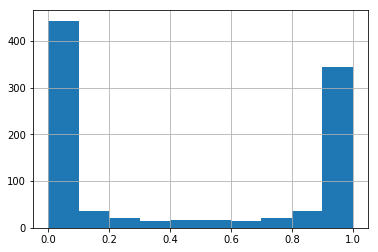

In [230]:
election_data[(election_data['forecast_type'] == 'classic') & (election_data['forecast_date'] == '2018-11-06')]['probwin'].hist()

Are most house elections easy to forecast or hard to forecast?

Yes most are easy to predict because they have extreme probabilities close to 0 or 1.

### Question 11: Comparing election and baseball predictions

Fivethirtyeight also builds predictive models for sporting events.  The following code will down a csv file containg their predictions for who would win every major league baseball game over the past two years.

In [191]:
!wget https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/mlb_games.csv    

--2019-04-19 20:21:28--  https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/mlb_games.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562029 (549K) [text/plain]
Saving to: ‘mlb_games.csv.1’

mlb_games.csv.1     100%[===================>] 548.86K  --.-KB/s    in 0.04s   

2019-04-19 20:21:28 (13.8 MB/s) - ‘mlb_games.csv.1’ saved [562029/562029]



Create a pandas dataframe from the csv and print the first 10 rows.

In [192]:
baseball = pd.read_csv("mlb_games.csv")
baseball.head(10)

,season,date,team1,team2,dh,prob1,prob1_outcome,prob2,prob2_outcome
0,2018,2018-10-28,Dodgers,Red Sox,0,0.483877,0.0,0.516123,1.0
1,2018,2018-10-27,Dodgers,Red Sox,0,0.508342,0.0,0.491658,1.0
2,2018,2018-10-26,Dodgers,Red Sox,0,0.555907,1.0,0.444093,0.0
3,2018,2018-10-24,Red Sox,Dodgers,0,0.619808,1.0,0.380192,0.0
4,2018,2018-10-23,Red Sox,Dodgers,0,0.648954,1.0,0.351046,0.0
5,2018,2018-10-20,Brewers,Dodgers,0,0.509500,0.0,0.490500,1.0
6,2018,2018-10-19,Brewers,Dodgers,0,0.505211,1.0,0.494789,0.0
7,2018,2018-10-18,Astros,Red Sox,0,0.603029,0.0,0.396971,1.0
8,2018,2018-10-17,Astros,Red Sox,0,0.568016,0.0,0.431984,1.0
9,2018,2018-10-17,Dodgers,Brewers,0,0.600428,1.0,0.399572,0.0


In this dataframe `prob1` is the predicted win probability for `team1`.  Make a histogram of `prob1`.  Set the limits of the x-axis to `[0, 1]`

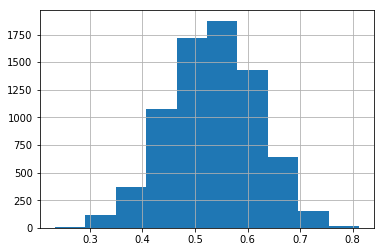

In [193]:
baseball['prob1'].hist()

### Question 12

Find the most "surprising" baseball game outcome.  To do so, select all of the entries for which `prob1_outcome` is 1 (i.e. `team1` won the game), and then look for the index of the row containing the smallest value of `prob1`.  This will correspond to the game that was most suprising according to fivethirtyeights predictions. Find and print the row corresponding to this most surprising outcome.

In [195]:
baseball.loc[baseball[baseball['prob1_outcome'] == 1]['prob1'].argmin()]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


season                 2018
date             2018-08-25
team1                Royals
team2               Indians
dh                        0
prob1              0.287558
prob1_outcome             1
prob2              0.712442
prob2_outcome             0
Name: 521, dtype: object

### Question 13
Are the outcomes of baseball games generally easier or harder to predict than the outcomes of political elections?  In a few sentences, comment on why this might be the case.  What data is available for these predictions? What factors affect the outcomes of elections and baseball games? What makes an event like an election or a baseballgame "random"?

Baseball outcomes seem harder to predict because there are less extreme values. For elections, on the day of, the probabilities for each candidate seem to be mostly close to 0 or 1 making it easy to say who will win. For baseball games, the probabilities are mostly towards .5 and there are very few extreme values. On the day of, people probably know by then who they want to vote for. Baseball game outcomes depend on the performance of each player making them harder to predict because each team's performance can vary greatly since it's hard to say how well a player will play that day.

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [ ]:
# Save your notebook first, then run this cell to submit.
ok.submit()

<IPython.core.display.Javascript object>